# Randomized Optimization

Which RO algorithms work best depends highly on the structure of the problem. In this notebook, we will compare how two commonly used RO algs perofrm on two problems with different structures. 

Note: GA's and SA's are both commonly used but there is not state of the art algorithm for all optimization problems. Good RO outcomes require understanding the structure of the problem and the algorithms strengths and weaknesses.....alternatively the structure of the problem can be inferred from the algorithm's performance :D


# Randomized Optimization Algorithms on Toy Problems

This notebook explores the performance of different randomized optimization (RO) algorithms on two classic toy problems: the **Traveling Salesman Problem (TSP)** and the **Knapsack Problem**.

---

## Problem Overview

TSP is a classic combinatorial optimization problem where the goal is to find the shortest possible route that visits each city exactly once and returns to the origin city. 

The Knapsack Problem involves selecting a subset of items with given weights and values to maximize total value without exceeding a weight limit.

| Problem       | Type                  | Input                         | Output                      | Challenge                            |
|---------------|-----------------------|-------------------------------|-----------------------------|--------------------------------------|
| **TSP**       | Permutation problem   | Distance matrix, cities       | Best route (permutation)    | Finding optimal cyclic permutation   |
| **Knapsack**  | Subset selection      | Weights, values, max capacity | Selected items (0/1 vector) | Best value under weight constraint   |


---

## RO Algorithm Strengths and Weaknesses

| Algorithm              | Strengths                                   | Weaknesses                          |
|------------------------|---------------------------------------------|-------------------------------------|
| **Genetic Algorithm**  | Good for large search spaces & multimodal   | Slower, parameter tuning needed     |
| **Simulated Annealing**| Simple, good global exploration             | May be slow to converge             |

### Genetic Algorithm (GA)

**Algorithm:**  
- Evolve a population of solutions using selection, crossover (recombination), and mutation.  
- Keep fitter individuals more likely to survive to the next generation.

**What it does:**  
- Searches large, complex, or multimodal spaces by mimicking natural evolution.  
- Maintains diversity and explores a wide variety of solutions.

**Strengths:**  
- Handles large, noisy, nonlinear, or discrete search spaces well.  
- Good at escaping local optima due to population-based search.  
- Flexible: works with both permutation (e.g. TSP) and binary/vector spaces (e.g. Knapsack).

**Weaknesses:**  
- Slower due to population overhead.  
- Requires careful tuning (population size, mutation rate, crossover type).  
- Can converge prematurely if diversity is lost.

**Good for:**  
- TSP, Knapsack, scheduling, neural architecture search, multimodal fitness landscapes.

**Less good for:**  
- Small search spaces, problems with fast greedy solutions, when runtime is limited.

### Simulated Annealing (SA)

**Algorithm:**  
- Start with an initial solution.  
- At each step, randomly perturb the solution.  
- Accept worse solutions with a decreasing probability (based on temperature).  
- Gradually "cool down" the system to settle into a minimum.

**What it does:**  
- Emulates annealing in metallurgy — controlled cooling to minimize energy.  
- Allows occasional uphill moves to escape local optima early in the process.

**Strengths:**  
- Simple and memory-efficient.  
- Effective at escaping local minima in early stages.  
- No need to maintain a population.

**Weaknesses:**  
- Sensitive to cooling schedule.  
- May converge slowly or poorly if not tuned.  
- No memory of past states, so can revisit bad solutions.

**Good for:**  
- Permutation-based problems like TSP.  
- Continuous or combinatorial optimization with many local minima.

**Less good for:**  
- Highly rugged or deceptive search spaces.  
- Problems with tight time/accuracy constraints.


---

## Expectations

How do we expect these RO algs to perform on TSP and Knapsack?

| Aspect                     | TSP (e.g. 10-50 cities)                     | Knapsack (e.g. 20-50 items)               |
|----------------------------|---------------------------------------------|-------------------------------------------|
| **Genetic Algorithm**      | Learns good tours with crossover/mutation   | Good balance between value/weight         |
| **Simulated Annealing**    | Can explore far and settle gradually        | Can get stuck if cooling is too fast      |
| **Runtime (small scale)**  | GA > SA                               | GA > SA                              |

## Setup Code

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import tracemalloc

In [ ]:
# --------------------------
# TSP Problem Setup
# --------------------------
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))


def total_tsp_distance(route, coords):
    return sum(
        euclidean_distance(coords[route[i]], coords[route[(i + 1) % len(route)]])
        for i in range(len(route))
    )


def generate_tsp_coordinates(n_cities, seed=42):
    np.random.seed(seed)
    return np.random.rand(n_cities, 2) * 100


# --------------------------
# Knapsack Problem Setup
# --------------------------
def generate_knapsack_items(
    n_items=50, weight_range=(1, 30), value_range=(10, 100), capacity_ratio=0.4, seed=42
):
    np.random.seed(seed)
    weights = np.random.randint(*weight_range, size=n_items)
    values = np.random.randint(*value_range, size=n_items)
    capacity = int(capacity_ratio * np.sum(weights))
    return weights, values, capacity


def knapsack_value(selection, weights, values, capacity):
    total_weight = np.dot(selection, weights)
    if total_weight > capacity:
        return 0  # Penalty for infeasibility
    return np.dot(selection, values)

### Genetic Algorithm for TSP

Note: GAs require you to define an initial population (set of candidate solutions...random permutations) to evolve, fitness function (eg. total distance), selection strategy, cross over function (eg. ordered for TSP), mutation function (eg. random swap of cities), etc. 

In [4]:
def ga_tsp(coords, n_generations=300, pop_size=100, mutation_rate=0.01):
    def init_population():
        # initialize population with random routes (permutations of city indices)
        return [np.random.permutation(len(coords)) for _ in range(pop_size)]

    def crossover(p1, p2):
        start, end = sorted(random.sample(range(len(p1)), 2))
        child = [-1] * len(p1)
        child[start:end] = p1[start:end]
        pointer = 0
        for gene in p2:
            if gene not in child:
                while child[pointer] != -1:
                    pointer += 1
                child[pointer] = gene
        return np.array(child)

    def mutate(route):
        if random.random() < mutation_rate:
            a, b = random.sample(range(len(route)), 2)
            route[a], route[b] = route[b], route[a]

    population = init_population()  # initial random population...routes
    best_route = None
    best_distance = float("inf")  # init as large as possible
    history = []  # to track best distance over generations

    for _ in range(n_generations):
        # sort population by fitness (distance)
        population = sorted(population, key=lambda r: total_tsp_distance(r, coords))
        # update best route if current best in population is better
        if total_tsp_distance(population[0], coords) < best_distance:
            best_route = population[0]
            best_distance = total_tsp_distance(best_route, coords)
        # track best distance over generations
        history.append(best_distance)

        # start next generation with top 10 routes (elitism)
        next_generation = population[:10]  # Elitism
        # fill in the rest of the population with crossover and mutation
        while len(next_generation) < pop_size:
            # randomly select 2 parents from top 50 (selection pressure)
            parents = random.choices(population[:50], k=2)
            # create a child via crossover
            child = crossover(parents[0], parents[1])
            # possibly mutate the child
            mutate(child)
            # add the child to the next generation
            next_generation.append(child)
        # replace old population with the new one
        population = next_generation

    return best_route, best_distance, history

### Simulated Annealing for TSP

In [ ]:
# --------------------------
# Simulated Annealing for TSP
# --------------------------
def sa_tsp(coords, T_init=1000, alpha=0.995, n_iter=10000):
    # swap 2 cities in a route
    def swap(route):
        a, b = random.sample(range(len(route)), 2)
        route[a], route[b] = route[b], route[a]
        return route

    # init: start with a random route and call that the "best"
    current = np.random.permutation(len(coords))
    best = current.copy()
    current_distance = total_tsp_distance(current, coords)
    best_distance = current_distance

    # set initial temperature and history (best distances over time)
    T = T_init
    history = [current_distance]

    for _ in range(n_iter):
        candidate = swap(current.copy())  # generate a neighbor by swapping two cities
        candidate_distance = total_tsp_distance(
            candidate, coords
        )  # eval neighbors distance
        delta = (
            candidate_distance - current_distance
        )  # how much better/worse is the candidate?
        if delta < 0 or np.random.rand() < np.exp(
            -delta / T
        ):  # accept if better or with some probability
            current = candidate
            current_distance = candidate_distance
            if candidate_distance < best_distance:
                best = candidate
                best_distance = candidate_distance
        history.append(
            best_distance
        )  # record best and gradually cool the system (low acceptance probability of worse solutions)
        T *= alpha

    return best, best_distance, history

### Genetic Algorithm for Knapsack

In [ ]:
# --------------------------
# Genetic Algorithm
# --------------------------
def ga_knapsack(
    weights, values, capacity, n_generations=200, pop_size=100, mutation_rate=0.05
):
    n_items = len(weights)

    def init_population():
        return [np.random.randint(0, 2, size=n_items) for _ in range(pop_size)]

    def mutate(solution):
        if random.random() < mutation_rate:
            idx = random.randint(0, n_items - 1)
            solution[idx] = 1 - solution[idx]

    def crossover(p1, p2):
        point = random.randint(1, n_items - 1)
        return np.concatenate((p1[:point], p2[point:]))

    population = init_population()
    best_solution = None
    best_value = 0
    history = []

    for _ in range(n_generations):
        population = sorted(
            population,
            key=lambda x: knapsack_value(x, weights, values, capacity),
            reverse=True,
        )
        if knapsack_value(population[0], weights, values, capacity) > best_value:
            best_solution = population[0]
            best_value = knapsack_value(best_solution, weights, values, capacity)
        history.append(best_value)

        next_generation = population[:10]  # Elitism
        while len(next_generation) < pop_size:
            parents = random.choices(population[:50], k=2)
            child = crossover(parents[0], parents[1])
            mutate(child)
            next_generation.append(child)
        population = next_generation

    return best_solution, best_value, history

### Simulated Annealing for Knapsack

In [14]:
# --------------------------
# Simulated Annealing
# --------------------------
def sa_knapsack(weights, values, capacity, T_init=100, alpha=0.98, n_iter=3000):
    n_items = len(weights)

    def flip_bit(solution):
        idx = random.randint(0, n_items - 1)
        solution[idx] = 1 - solution[idx]
        return solution

    current = np.random.randint(0, 2, size=n_items)
    best = current.copy()
    current_value = knapsack_value(current, weights, values, capacity)
    best_value = current_value
    T = T_init
    history = [current_value]

    for _ in range(n_iter):
        candidate = flip_bit(current.copy())
        candidate_value = knapsack_value(candidate, weights, values, capacity)
        delta = candidate_value - current_value
        if delta > 0 or np.random.rand() < np.exp(delta / T):
            current = candidate
            current_value = candidate_value
            if candidate_value > best_value:
                best = candidate
                best_value = candidate_value
        history.append(best_value)
        T *= alpha

    return best, best_value, history

## Run Experiments

Measure runtime, memory and best score for each algorithm on both problems.

### TSP

In [6]:
# generate coordinates for TSP
coords = generate_tsp_coordinates(n_cities=25)
print("Coordinates for TSP:", coords)

Coordinates for TSP: [[37.45401188 95.07143064]
 [73.19939418 59.86584842]
 [15.60186404 15.59945203]
 [ 5.80836122 86.61761458]
 [60.11150117 70.80725778]
 [ 2.05844943 96.99098522]
 [83.24426408 21.23391107]
 [18.18249672 18.34045099]
 [30.4242243  52.47564316]
 [43.19450186 29.12291402]
 [61.18528947 13.94938607]
 [29.21446485 36.63618433]
 [45.60699842 78.51759614]
 [19.96737822 51.42344384]
 [59.24145689  4.64504127]
 [60.75448519 17.05241237]
 [ 6.5051593  94.88855373]
 [96.56320331 80.83973481]
 [30.46137692  9.7672114 ]
 [68.42330265 44.01524937]
 [12.20382348 49.51769101]
 [ 3.43885211 90.93204021]
 [25.87799816 66.25222844]
 [31.17110761 52.00680212]
 [54.67102793 18.48544555]]


In [7]:
# --- Measure GA performance ---
tracemalloc.start()
start_time = time.perf_counter()
ga_route, ga_dist, ga_history = ga_tsp(coords)
end_time = time.perf_counter()
ga_time = end_time - start_time
ga_mem_current, ga_mem_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(
    f"GA TSP: Best Distance = {ga_dist}, Time = {ga_time:.2f}s, Memory = {ga_mem_current / 1024:.2f}KB (Peak: {ga_mem_peak / 1024:.2f}KB)"
)

GA TSP: Best Distance = 523.5145741618214, Time = 7.70s, Memory = 16.69KB (Peak: 77.29KB)


In [8]:
# --- Measure SA performance ---
tracemalloc.start()
start_time = time.perf_counter()
sa_route, sa_dist, sa_history = sa_tsp(coords)
end_time = time.perf_counter()
sa_time = end_time - start_time
sa_mem_current, sa_mem_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(
    f"SA TSP: Best Distance = {sa_dist}, Time = {sa_time:.2f}s, Memory = {sa_mem_current / 1024:.2f}KB (Peak: {sa_mem_peak / 1024:.2f}KB)"
)

SA TSP: Best Distance = 610.5479333111537, Time = 2.23s, Memory = 87.12KB (Peak: 97.07KB)


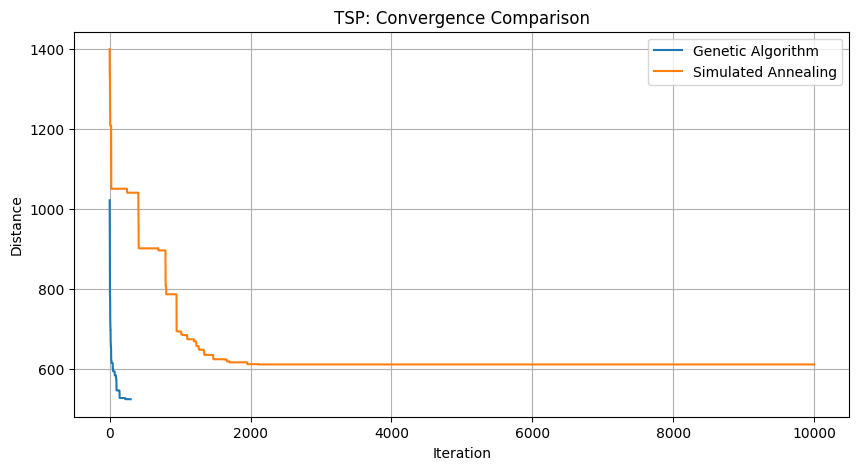

In [10]:
# --------------------------
# Plot Convergence
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(ga_history, label="Genetic Algorithm")
plt.plot(sa_history, label="Simulated Annealing")
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.title("TSP: Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()

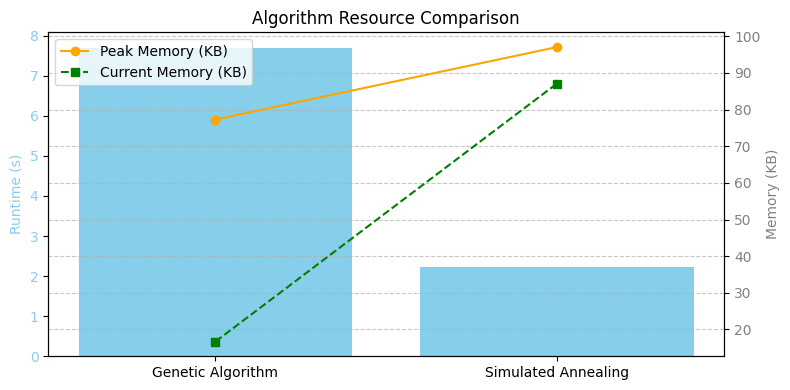

In [ ]:
# Plot runtime and memory comparison
algos = ["Genetic Algorithm", "Simulated Annealing"]
runtimes = [ga_time, sa_time]
mem_current = [ga_mem_current / 1024, sa_mem_current / 1024]  # in KB
mem_peak = [ga_mem_peak / 1024, sa_mem_peak / 1024]  # in KB

fig, ax1 = plt.subplots(figsize=(8, 4))

# Runtime bars (left y-axis)
ax1.bar(algos, runtimes, color="skyblue")
ax1.set_ylabel("Runtime (s)", color="skyblue")
ax1.tick_params(axis="y", labelcolor="skyblue")
ax1.set_title("Algorithm Resource Comparison")

# Memory lines (right y-axis)
ax2 = ax1.twinx()
ax2.plot(algos, mem_peak, color="orange", marker="o", label="Peak Memory (KB)")
ax2.plot(
    algos,
    mem_current,
    color="green",
    marker="s",
    linestyle="--",
    label="Current Memory (KB)",
)
ax2.set_ylabel("Memory (KB)", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

So, GA found a better solution but took longer to run. 

It also used less memory in our implementation...but wait???....isn't SA is supposed to be more memory efficient? Yes, but in our implementation we store the entire history. A better implementation may cap history length or optimize swap, etc

### Knapsack

Goal: maximize value without exceeding weight limit.

In [15]:
weights, values, capacity = generate_knapsack_items()

In [16]:
# --- Measure GA performance ---
tracemalloc.start()
start_ga = time.perf_counter()
ga_sol, ga_val, ga_hist = ga_knapsack(weights, values, capacity)
end_ga = time.perf_counter()
ga_time = end_ga - start_ga
ga_mem_current, ga_mem_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(
    f"GA Knapsack: Best Value = {ga_val}, Time = {ga_time:.2f}s, Memory = {ga_mem_current / 1024:.2f}KB (Peak: {ga_mem_peak / 1024:.2f}KB)"
)

GA Knapsack: Best Value = 1824, Time = 0.26s, Memory = 5.74KB (Peak: 103.04KB)


In [17]:
# --- Measure SA performance ---
tracemalloc.start()
start_sa = time.perf_counter()
sa_sol, sa_val, sa_hist = sa_knapsack(weights, values, capacity)
end_sa = time.perf_counter()
sa_time = end_sa - start_sa
sa_mem_current, sa_mem_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(
    f"SA Knapsack: Best Value = {sa_val}, Time = {sa_time:.2f}s, Memory = {sa_mem_current / 1024:.2f}KB (Peak: {sa_mem_peak / 1024:.2f}KB)"
)

SA Knapsack: Best Value = 1342, Time = 0.06s, Memory = 28.61KB (Peak: 38.54KB)


So GA found a better solution but took longer to run.

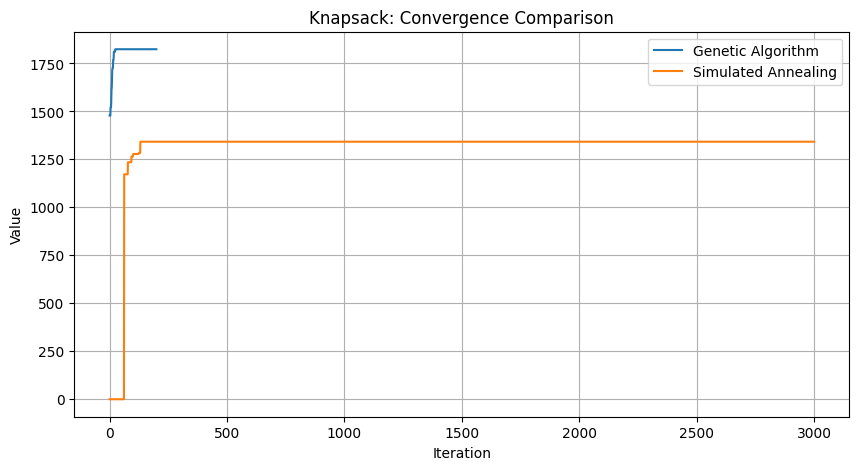

In [18]:
# --------------------------
# Plot Convergence
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(ga_hist, label="Genetic Algorithm")
plt.plot(sa_hist, label="Simulated Annealing")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Knapsack: Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()

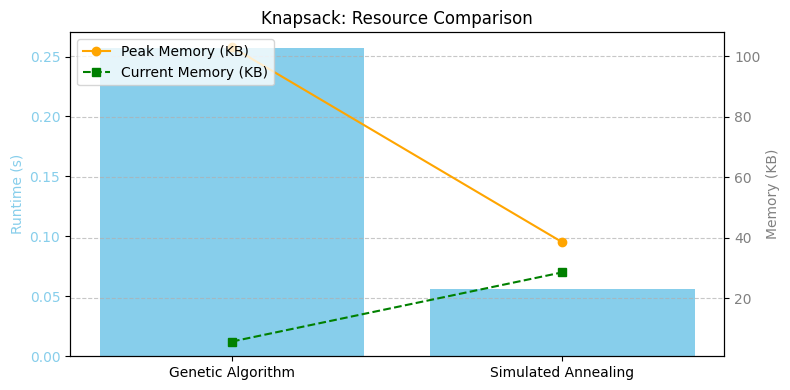

In [ ]:
# --------------------------
# Combined Runtime & Memory Plot
# --------------------------
algos = ["Genetic Algorithm", "Simulated Annealing"]
runtimes = [ga_time, sa_time]
mem_current = [ga_mem_current / 1024, sa_mem_current / 1024]
mem_peak = [ga_mem_peak / 1024, sa_mem_peak / 1024]

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.bar(algos, runtimes, color="skyblue")
ax1.set_ylabel("Runtime (s)", color="skyblue")
ax1.tick_params(axis="y", labelcolor="skyblue")
ax1.set_title("Knapsack: Resource Comparison")

ax2 = ax1.twinx()
ax2.plot(algos, mem_peak, color="orange", marker="o", label="Peak Memory (KB)")
ax2.plot(
    algos,
    mem_current,
    color="green",
    marker="s",
    linestyle="--",
    label="Current Memory (KB)",
)
ax2.set_ylabel("Memory (KB)", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Again, our implementation of SA stored the entire history, which is not memory efficient.


---

## Summary: Experimental Results vs Expectations

Overall, our expectations aligned fairly well with results....Genetic Algorithm is slower but more robust for complex or multimodal spaces. Simulated Annealing is faster but seems more sensitive to parameter tuning and problem structure....gets stuck. We didn't expect SA to have such poor memory but that was due to our implementation choice more than a feature of the algorithm itself.

| Aspect                   | TSP Results                                                                   | Knapsack Results                                                                 |
|--------------------------|--------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| Genetic Algorithm        | Found a better route than Simulated Annealing, with longer runtime            | Achieved a significantly higher total value than Simulated Annealing, with longer runtime |
| Simulated Annealing      | Produced a reasonable solution quickly but did not reach the best quality     | Produced a lower-value solution quickly; less effective on the problem landscape |
| Runtime                  | Matched expectation: Genetic Algorithm was slower than Simulated Annealing    | Matched expectation: Genetic Algorithm was slower than Simulated Annealing       |
| Memory Usage             | Simulated Annealing had higher peak memory due to route copying and history   | Simulated Annealing had higher peak memory due to repeated bit flips and state storage |
| Algorithm Behavior       | Simulated Annealing explored well early, but Genetic Algorithm exploited better over time | Genetic Algorithm balanced exploration and exploitation more effectively; Simulated Annealing likely cooled too quickly |

---

### Possible Improvements

- Tune cooling schedule in Simulated Annealing to maintain exploration longer?
- Try adaptive mutation rates in Genetic Algorithm to preserve diversity?
- Cap memory usage in Simulated Annealing by limiting history length?